---
## Step 0: Load The Data

In [2]:
# This section loads the training and the testing data sets

# Load pickled data
import pickle

training_file = '/home/carnd/train.p'
testing_file = '/home/carnd/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
# This section implements exploratory code to ascertain the shape and size of the data loaded

# Number of training examples
n_train = len(train['labels'])

# Number of testing examples.
n_test = len(test['labels'])

# The shape of an traffic sign image?
L = len(X_train[0])
W = len(X_train[0][0])
H = len(X_train[0][0][0])
image_shape = [L, W, H]

# Number of unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = [32, 32, 3]
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

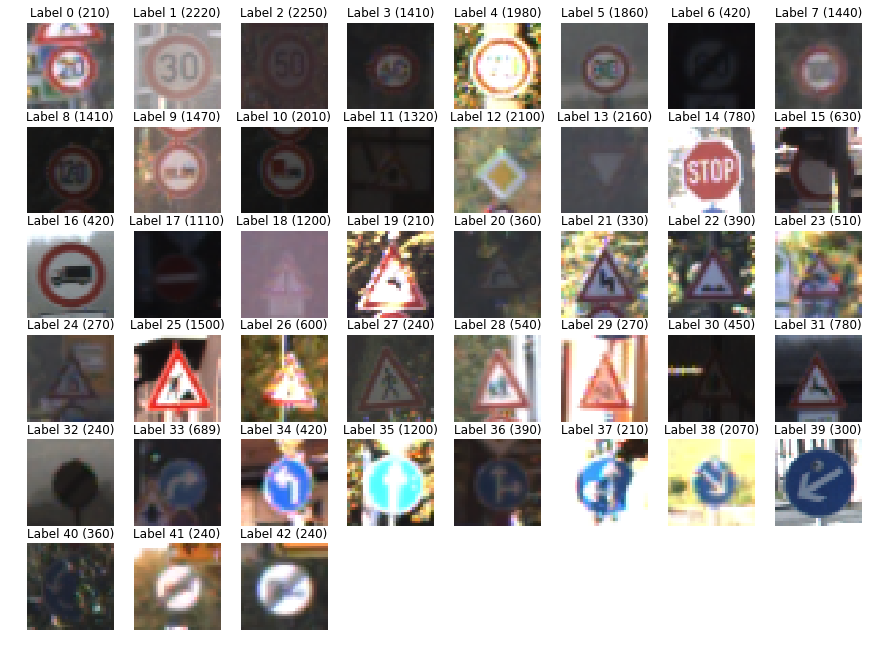

In [4]:
# This section visualizes one representative images each of all 43 traffic signs 
# loaded as part of the training data set

import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

def display_images_and_labels(images, labels):
    """Display the images of the dataset as well as the labels.
    
    parameters:
        - images: is a numpy array of images.
        - labels: is a list with labels.
        
    Code adapted from waleedka @ github.
    """
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]

        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        plt.imshow(image)
    plt.show()
    return

display_images_and_labels(X_train, y_train.tolist())


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [5]:
# This section pre-processes both the training data and the testing data.
# A detailed description of the steps taken to pre-process can be found in the answer to Question 1 below.

from sklearn.utils import shuffle
import numpy as np
import cv2

# shuffle the data
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)


In [6]:
# Convert image to YUV channels and retain only the Y channel

X_train_yuv = np.empty(shape = (n_train, 32, 32), dtype = np.uint8)
X_test_yuv = np.empty(shape = (n_test, 32, 32), dtype = np.uint8)

# Apply localized histogram equalization to the Y channel
clahe = cv2.createCLAHE()

for i in range(0, n_train):
    curr_image = X_train[i]
    temp = cv2.cvtColor(curr_image, cv2.COLOR_RGB2YUV)
    y, u, v = cv2.split(temp)
    X_train_yuv[i] = clahe.apply(y)

for i in range(0, n_test):
    curr_image = X_test[i]
    temp = cv2.cvtColor(curr_image, cv2.COLOR_RGB2YUV)
    y, u, v = cv2.split(temp)
    X_test_yuv[i] = clahe.apply(y)


Max pixel value:  255
Min pixel value:  16


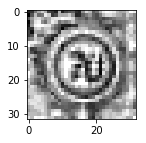

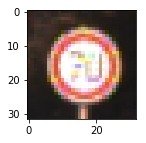

In [7]:
# Sanity check code

index = 21042 # manually assigned random index number
# display the image obtained after pre-processing
plt.figure(figsize = (2,2))
plt.imshow(X_train_yuv[index], cmap = 'gray')

# display the corresponding original image as it existed before pre-processing
img = X_train[index]
plt.figure(figsize=(2,2))
plt.imshow(img)

print("Max pixel value: ", np.amax(X_train_yuv[index]))
print("Min pixel value: ", np.amin(X_train_yuv[index]))

# delete obsolete variables so as to save space
del X_train

In [8]:

# normalize all pixel values between -1 and 1
X_train_norm = (X_train_yuv - 128.0) / 128.0
X_test_norm = (X_test_yuv - 128.0) / 128.0

print("Max before norm for train ", np.amax(X_train_yuv))
print("Max after norm for train ", np.amax(X_train_norm))
print("Min before norm for train ", np.amin(X_train_yuv))
print("Min after norm for train ", np.amin(X_train_norm))

print("Max before norm for test ", np.amax(X_test_yuv))
print("Max after norm for test ", np.amax(X_test_norm))
print("Min before norm for test ", np.amin(X_test_yuv))
print("Min after norm for test ", np.amin(X_test_norm))

# Sanity check
print(X_train_norm.shape)
print(X_test_norm.shape)

# delete obsolete variables so as to save space
del X_train_yuv
#del X_train_norm
del X_test_yuv
#del X_test_norm



Max before norm for train  255
Max after norm for train  0.9921875
Min before norm for train  4
Min after norm for train  -0.96875
Max before norm for test  255
Max after norm for test  0.9921875
Min before norm for test  4
Min after norm for test  -0.96875
(39209, 32, 32)
(12630, 32, 32)


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

To pre-process the data, the following steps were taken in that order: <br>
--> Randomly shuffle the training data and test data<br>
    Reason: To prevent the CNN from reading too much into the sequence that the training data is arranged in<br>
--> Convert the RGB color space to YUV and extract the Y channel<br>
    Reason: To reduce the size of training data especially since color contains no additional useful information<br>
--> Apply localized histogram equalization on the Y channel<br>
    Reason: To improve the contrast of the image<br>
--> Normlize the pixel values between -1 and 1<br>
    Reason: To ease the convergence of the error function by feeding it standardized small numbers only<br>

In [9]:
# This section sets aside 20% of the original testing set data as the validation set.

from sklearn.cross_validation import train_test_split

# define train_size to be 80% of the training data and validation_size to be 20%
train_size = int(np.floor(0.8 * n_train))
validation_size = int(n_train - train_size)
print("Training size: ", train_size, "Validation size:" , validation_size)

X_train_final = np.empty(shape = (train_size, 32, 32), dtype = np.uint8)
y_train_final = np.empty(shape = (train_size), dtype = np.uint8)
X_valid_final = np.empty(shape = (validation_size, 32, 32), dtype = np.uint8)
y_valid_final = np.empty(shape = (validation_size), dtype = np.uint8)

# split the training set and the validation set
X_train_final, X_valid_final, y_train_final, y_valid_final = train_test_split(X_train_norm, y_train, test_size=0.2)    

# leave these unchanged
X_test_final = X_test_norm
y_test_final = y_test

# delete obsolete variables so as to save space
del X_test_norm
del y_test
del X_train_norm
del y_train

X_train_final = X_train_final.reshape(train_size, 32, 32, 1)
X_valid_final = X_valid_final.reshape(validation_size, 32, 32, 1)
X_test_final = X_test_final.reshape(n_test, 32, 32, 1)
y_test_final = y_test_final.reshape(n_test)
    
assert(len(X_train_final) == len(y_train_final))
assert(len(X_valid_final) == len(y_valid_final))
assert(len(X_test_final) == len(y_test_final))

Training size:  31367 Validation size: 7842


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

The given training data, which was shuffled in a previous step, was split into two groups of sizes 80% and 20% respectively using the train_test_split function. The former set was set aside as the training set and the latter as validation set. The testing set was already provided and needed no further splitting.

In [10]:
# This section defines the architecture of the Convolutional Neural Network.
# The details of the architecture are described in the answer to Question 3.

import tensorflow as tf

EPOCHS = 2000 # maximum number of epochs
BATCH_SIZE = 128


In [11]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x80.
    layer_1 = {
                'wc': tf.Variable(tf.truncated_normal([5, 5, 1, 80], mu, sigma)), 
                'bc': tf.Variable(tf.truncated_normal([80], mu, sigma))}
    
    x = tf.nn.conv2d(x, layer_1['wc'], strides = [1, 1, 1, 1], padding = 'VALID')
    x = tf.nn.bias_add(x, layer_1['bc'])
    
    # TODO: Activation.
    x = tf.nn.relu(x)
    x = tf.nn.dropout(x, 0.75)

    # TODO: Pooling. Input = 28x28x80. Output = 14x14x80.
    x = tf.nn.max_pool(x, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')

    # TODO: Layer 2: Convolutional. Input = 14x14x80. Output = 10x10x100.
    layer_2 = {
                'wc': tf.Variable(tf.truncated_normal([5, 5, 80, 100], mu, sigma)), 
                'bc': tf.Variable(tf.truncated_normal([100], mu, sigma))}
        
    x = tf.nn.conv2d(x, layer_2['wc'], strides = [1, 1, 1, 1], padding = 'VALID')
    x = tf.nn.bias_add(x, layer_2['bc'])
    
    # TODO: Activation.
    x = tf.nn.relu(x)
    x = tf.nn.dropout(x, 0.75)

    # TODO: Pooling. Input = 10x10x100. Output = 5x5x100.
    x = tf.nn.max_pool(x, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')

    # TODO: Flatten. Input = 5x5x100. Output = 250.
    x = flatten(x)
    
    # TODO: Layer 3: Fully Connected. Input = 2500. Output = 500.
    layer_3 = {
                'wc': tf.Variable(tf.truncated_normal([2500, 500], mu, sigma)), 
                'bc': tf.Variable(tf.truncated_normal([500], mu, sigma))}
    
    x = tf.add(tf.matmul(x, layer_3['wc']), layer_3['bc'])
    
    # TODO: Activation.
    x = tf.nn.relu(x)
    x = tf.nn.dropout(x, 0.75)

    # TODO: Layer 4: Fully Connected. Input = 500. Output = 60.
    layer_4 = {
                'wc': tf.Variable(tf.truncated_normal([500, 60], mu, sigma)), 
                'bc': tf.Variable(tf.truncated_normal([60], mu, sigma))}
    
    x = tf.add(tf.matmul(x, layer_4['wc']), layer_4['bc'])
    
    # TODO: Activation.
    x = tf.nn.relu(x)
    x = tf.nn.dropout(x, 0.75)

    # TODO: Layer 5: Fully Connected. Input = 60. Output = 43.
    layer_5 = {
                'wc': tf.Variable(tf.truncated_normal([60, 43], mu, sigma)), 
                'bc': tf.Variable(tf.truncated_normal([43], mu, sigma))}
    
    x = tf.add(tf.matmul(x, layer_5['wc']), layer_5['bc'])
    
    logits = x
    
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

The final architecture consists of the following:<br>
--> Input: 32x32 image pixels<br>
--> Layer 1: Convolutional layer with Eighty 5x5x1 filters<br>
--> Layer 2: Convolutional layer with Hundred 5x5x80 filters<br>
--> Layer 3: Fully connected layer with 2500 inputs and 500 ouputs<br>
--> Layer 4: Fully connected layer with 500 inputs and 60 outputs<br>
--> Layer 5: Fully connected layer with 60 inputs and 43 outputs<br>

Convolution in the first 2 layers were accomplished with "valid" zero-padding a stride of one.
Each of the two convolutional layers were followed by max pooling with a stride of two.
The ReLU activation function was used after each of the first 4 layers.
Dropout with a probability to keep of 75% was used after each of the first 4 layers.


In [12]:
# This section trains the model defined in the previous section.

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

rate = 0.0001 # learning rate

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


In [13]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_final)
    
    print("Training...")
    print()

    for i in range(EPOCHS):
        
        X_train_final, y_train_final = shuffle(X_train_final, y_train_final)
        for offset in range(0, num_examples, BATCH_SIZE):
            #print(offset)
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_final[offset:end], y_train_final[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
        
        #print("Shape is: ", y_valid_final.shape)
        validation_accuracy = evaluate(X_valid_final, y_valid_final)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
        if validation_accuracy > 0.994:  # stop iterating once validation accuracy exceeds 99.4%
            print("Validation accuracy exceeding 99.2% achieved. Stopping training")
            break
    
    # save model
    saver.save(sess, 'lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.264

EPOCH 2 ...
Validation Accuracy = 0.463

EPOCH 3 ...
Validation Accuracy = 0.585

EPOCH 4 ...
Validation Accuracy = 0.676

EPOCH 5 ...
Validation Accuracy = 0.739

EPOCH 6 ...
Validation Accuracy = 0.779

EPOCH 7 ...
Validation Accuracy = 0.815

EPOCH 8 ...
Validation Accuracy = 0.841

EPOCH 9 ...
Validation Accuracy = 0.855

EPOCH 10 ...
Validation Accuracy = 0.874

EPOCH 11 ...
Validation Accuracy = 0.887

EPOCH 12 ...
Validation Accuracy = 0.895

EPOCH 13 ...
Validation Accuracy = 0.905

EPOCH 14 ...
Validation Accuracy = 0.916

EPOCH 15 ...
Validation Accuracy = 0.917

EPOCH 16 ...
Validation Accuracy = 0.923

EPOCH 17 ...
Validation Accuracy = 0.930

EPOCH 18 ...
Validation Accuracy = 0.939

EPOCH 19 ...
Validation Accuracy = 0.939

EPOCH 20 ...
Validation Accuracy = 0.942

EPOCH 21 ...
Validation Accuracy = 0.948

EPOCH 22 ...
Validation Accuracy = 0.948

EPOCH 23 ...
Validation Accuracy = 0.952

EPOCH 24 ...
Validation Accura

In [14]:
with tf.Session() as sess:
    #saver.restore(sess, tf.train.latest_checkpoint('.'))
    saver.restore(sess, '/home/carnd/CarND-Traffic-Sign-Classifier-Project/lenet')
    test_accuracy = evaluate(X_test_final, y_test_final)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.962


Question 4:<br>
Type of Optimizer: Adam Optimizer<br>
Batch Size: 128<br>
Maximum Number of Epochs: 2000 (training stopped during whichever epoch the validation accuracy exceeds 99.4%)<br>
Learning Rate: 0.0001<br>

Question 5:<br>
The approach taken was to start with the standard LeNet architecture introduced in the lab section of this project and change the number and size of filters in the convolutional layer. An empirical approach was taken to determine the appripriate size of the CNN. 

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [15]:
# This section loads images of traffic signs found on the web that the model has never seen before.
# The images are then displayed.

# Re-import so to be able to re-start from here.
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
import cv2

# Visualizations will be shown in the notebook.
%matplotlib inline

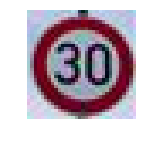

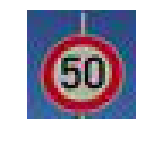

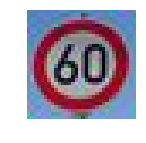

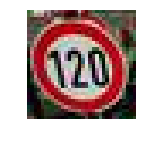

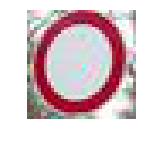

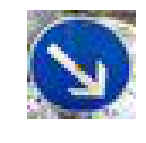

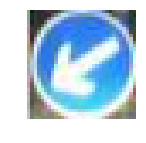

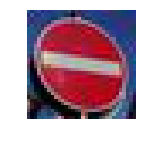

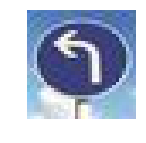

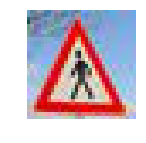

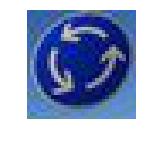

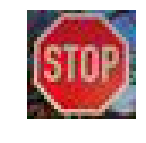

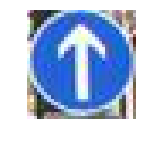

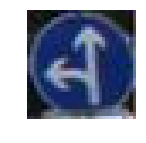

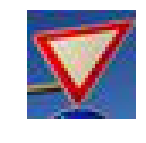

In [16]:
# Load the images and plot them here.

files = ['30', '50', '60', '120', 'circle', 'diagonal', 'diagonal2', 'donotenter',
        'leftonly', 'pedestrian', 'rotary', 'stop', 'straight', 'straightleft',
        'yield']

num_new_imgs = len(files)

# load the new images into an array
example = np.empty(shape = (num_new_imgs, 1, 32, 32, 1), dtype = np.float32)

# construct an array of labels corresponding to the image files in the correct order
example_labels = np.array([1, 2, 3, 8, 15, 38, 39, 17, 34, 27, 40, 14, 35, 37, 13])

for i in range(num_new_imgs):

    image_bgr = cv2.imread('/home/carnd/CarND-Traffic-Sign-Classifier-Project/' + files[i] + '.jpg')
    image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(2,2))
    plt.axis('off')
    
    resized = image # since images are already 32x32, there is no need to resize them
    plt.imshow(resized)

    bw = cv2.cvtColor(resized, cv2.COLOR_RGB2YUV)
    y, u, v = cv2.split(bw)

    y_new = np.empty([32, 32], dtype=np.uint8)

    clahe = cv2.createCLAHE()
    y_new = clahe.apply(y)

    y_new_II = np.float32((y_new - 128.0) / 128.0)
    y_new_III = y_new_II.reshape(1, 32, 32, 1)
    #y_new_III = y_new_II.reshape(32, 32, 1)
    example[i] = y_new_III
    



### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

The candidate images chosen are 15 in number and displayed above. Superficially, there is nothing about these images that should pose problems for the model because they appear to be similar to the kinds of images the model was exposed to during training. However, because no new data was generated during training to explicitly account for transformations such as rotation and shearing, a few of these 15 images may be misclassified by the model.

In [19]:
# This section runs the prediction on the 15 new images by feeding them forward in the CNN.
# The accuracy is printed at the bottom.

from scipy import stats

softmax_func = tf.nn.softmax(logits)
predicted_label = np.empty(shape = (num_new_imgs), dtype = np.uint8)
softmax_array = np.empty(shape = (num_new_imgs, 43))

def evaluate_new_img(X_data):
    num_examples = len(X_data)
    #print(num_examples)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(num_examples):
        batch_x = X_data
        softmax_array = sess.run(softmax_func, feed_dict = {x:batch_x})
        # Extract the label with the highest probability
        most_frequent_label = np.argmax(softmax_array)
        return (most_frequent_label, softmax_array)

def new_img_accuracy(predicted_label, example_labels):
    counter = 0
    for i in range(len(predicted_label)):
        if predicted_label[i] == example_labels[i]:
            counter += 1
    return counter / len(predicted_label)
        

for i in range(num_new_imgs):
    with tf.Session() as sess:
        saver.restore(sess, '/home/carnd/CarND-Traffic-Sign-Classifier-Project/lenet')
        [output1, output2] = evaluate_new_img(example[i])
        predicted_label[i] = output1
        softmax_array[i] = output2
        
new_img_accuracy = new_img_accuracy(predicted_label, example_labels)
print("New Image Accuracy = {:.3f}".format(new_img_accuracy))


New Image Accuracy = 0.800


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

The model was able to classify 12 of the 15 images correctly for an accuracy rate of 80% compared to the accuracy rate of 96.2% for the testing set. 

In [20]:
# This section prints the top 5 softmax probabilities for each of the 15 new images

with tf.Session() as sess:
    top_k_probs = sess.run(tf.nn.top_k(tf.constant(softmax_array), k = 5))

print(top_k_probs)

TopKV2(values=array([[  9.99968171e-01,   2.63738639e-05,   4.68735698e-06,
          7.50226036e-07,   6.17151699e-08],
       [  9.99999166e-01,   7.83101029e-07,   2.56666549e-10,
          1.26834754e-13,   5.35310211e-15],
       [  9.99820173e-01,   1.79860042e-04,   9.81819692e-09,
          1.03036094e-10,   4.54119763e-11],
       [  9.94313836e-01,   4.92876256e-03,   4.55440837e-04,
          2.16037603e-04,   6.87805659e-05],
       [  8.03045154e-01,   1.14415221e-01,   4.66677025e-02,
          1.21785123e-02,   8.98839626e-03],
       [  9.99995470e-01,   4.08364895e-06,   4.28928075e-07,
          1.74526864e-08,   1.69015024e-08],
       [  8.22976112e-01,   1.27817065e-01,   4.05112356e-02,
          3.47051490e-03,   3.35530122e-03],
       [  1.00000000e+00,   3.33055764e-16,   7.18568357e-17,
          2.48550321e-18,   2.57544881e-19],
       [  9.96388078e-01,   3.07893544e-03,   2.91541102e-04,
          2.22197152e-04,   9.63588354e-06],
       [  9.99727070e-0

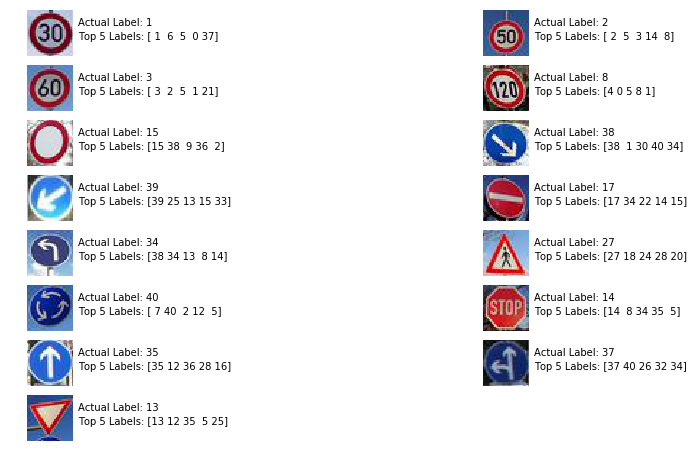

In [21]:
# This section displays the actual label and the top 5 predicted labels against each of the 15 original images.
# An assessment of the accuracy can be found in the answer to question 8 below.

plt.figure(figsize=(15, 15))

for i in range(num_new_imgs):

    image_bgr = cv2.imread('/home/carnd/CarND-Traffic-Sign-Classifier-Project/' + files[i] + '.jpg')
    image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    
    plt.subplot(15, 2, i + 1)
    plt.axis('off')
    
    # perform the actual resizing of the image and show it
    resized = cv2.resize(image, (32, 32))
    plt.imshow(resized)
    plt.text(35, 10, "Actual Label: " + str(example_labels[i]))
    plt.text(35, 20, "Top 5 Labels: " + str(top_k_probs.indices[i]))
       

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

Question 8:
Of the 15 images, 12 are classified accurately in that their highest softmax probabilies also correspond to the correct labels.The three misclassified images belong to the "Left Only" sign (Label 34), the "Rotary" sign (Label 40) and the "120 km/hr" sign (Label 8). For the former two, the correct label corresponds to the second highest softmax probability meaning that although the model misclassified them, it was not way off in its prediction. For the 120 km/hr sign, however, the correct label has the 4th highest probability. This, therefore, is the only traffic sign, among 15, for which the model was unquestionably wrong.